In [1]:
from sentence_transformers import SentenceTransformer, LoggingHandler
import numpy as np

In [3]:
model = SentenceTransformer('bert-base-nli-mean-tokens')


100%|██████████| 405M/405M [01:08<00:00, 5.89MB/s] 


In [28]:
sentences = ['can polycythemia cause stroke', 
    'Thrombotic strokes can affect large or small arteries in the brain. When a thrombotic stroke occurs in a small artery deep within the brain, the stroke is called a lacunar stroke. Embolic strokes - In an embolic stroke, a blood clot or other solid mass of debris travels to the brain, where it blocks a brain artery.',
     "Menstrual bleeding usually results from a decrease in natural hormone levels about 14 days after the ovulation, if you're not pregnant. The average woman takes one month to three months to start ovulating again after stopping the pill. Sometimes ovulation may occur sooner; other times, it may take longer.f you don't get your period for some time after stopping the pill chances are that you are either pregnant (do a pregnancy test!) or you did not ovulate. Even without getting your period first there might be a chance you are pregnant.",
     "ice cream"]
sentence_embeddings = model.encode(sentences)

In [29]:
len(sentence_embeddings)

4

In [30]:
sentence_embeddings[1].shape

(768,)

In [31]:
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding.shape)
    print("")

Sentence: can polycythemia cause stroke
Embedding: (768,)

Sentence: Thrombotic strokes can affect large or small arteries in the brain. When a thrombotic stroke occurs in a small artery deep within the brain, the stroke is called a lacunar stroke. Embolic strokes - In an embolic stroke, a blood clot or other solid mass of debris travels to the brain, where it blocks a brain artery.
Embedding: (768,)

Sentence: Menstrual bleeding usually results from a decrease in natural hormone levels about 14 days after the ovulation, if you're not pregnant. The average woman takes one month to three months to start ovulating again after stopping the pill. Sometimes ovulation may occur sooner; other times, it may take longer.f you don't get your period for some time after stopping the pill chances are that you are either pregnant (do a pregnancy test!) or you did not ovulate. Even without getting your period first there might be a chance you are pregnant.
Embedding: (768,)

Sentence: ice cream
Embed

In [32]:
sentence_embeddings[0].shape

(768,)

In [ ]:
# Evaluation below

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
cosine_similarity(sentence_embeddings[0].reshape(-1,1).T, Y=sentence_embeddings[1:])

array([[0.6045091 , 0.4425732 , 0.12299903]], dtype=float32)

In [126]:
import pandas as pd

In [185]:
queries_file= '/run/media/root/Windows/Users/agnes/Downloads/data/msmarco/queries_od.csv'

df = pd.read_csv(queries_file)

df.head(3)

,qid,query,rel,type,doc
0,0,are cnn ratings falling,0,original,Mustard greens are also a good food choice for...
1,0,are cnn ratings falling,0,original,The only concessions Jay obtained was a surren...
2,0,are cnn ratings falling,0,original,Allen: Constitution Prevails Over President's ...


In [154]:
def calc_rr(rels_sorted, types_sorted, ttype='original', rel_label=1):
    indices = np.where(rels_sorted == rel_label)[0]
    #print(indices)
    original = np.where(types_sorted[indices] == ttype)[0]
    if len(original) == 0:
        raise Exception('no relevant docs of this type')
    return np.mean(1 / (indices[original]+1))


In [ ]:

types = ['original', 'degree_2', 'degree_3', 'degree_4', 'degree_4_split', 'degree_8', 'degree_8_split']

rr_df = pd.DataFrame(columns=['qid'] + types + ['original_irrelevant'])

qids = list(set(df['qid']))
nr_qids = len(qids)
for i, qid in enumerate(qids):
    query_df = df[df['qid'] == qid].reset_index(drop=True)
    query = query_df['query'].iloc[0]
    print('query:', query)
    rels = query_df[query_df['rel'] == 1]['doc'].values.tolist()
   
    # TODO: abstract ranking part out
    ###
    embeddings = model.encode([query] + query_df['doc'].values.tolist())
    
    sims = cosine_similarity(embeddings[0].reshape(-1,1).T, 
                      Y=embeddings[1:])    
    indexed_sims = enumerate(sims.squeeze())   
    indexed_sims_sorted = sorted(indexed_sims, key=lambda x:x[1], reverse=True)
    indices_sorted = [x[0] for x in indexed_sims_sorted]
    ####
    
    docs_sorted = query_df.iloc[indices_sorted]
    
    row_to_add = [qid]
    for ttype in types:
        row_to_add.append(calc_rr(docs_sorted['rel'].values, docs_sorted['type'].values, ttype=ttype))
    row_to_add.append(calc_rr(docs_sorted['rel'].values, docs_sorted['type'].values, ttype='original', 
                      rel_label=0))
    rr_df = rr_df.append(pd.Series(row_to_add, index=rr_df.columns), ignore_index=True)
    
    if i % 5 ==  0:
        print('processed {:d} of {:d}'.format(i, nr_qids)
rr_df

query: are cnn ratings falling
query: can polycythemia cause stroke
query: cancer of the pancreas symptoms
query: amnesty define
query: can you have a high magnesium with high calcium
query: an electron group is defined as
query: can you get pregnant day one of your period
query: can ciprofloxacin be used to treat pneumonia
query: are most favored nation clauses legal
query: amnesty definition
query: how large is the canadian military
query: how much does it cost to run lines from heat pump
query: does cost less to run a heat pump
query: cost to install struts
query: average life of well pump
query: average cost to install fiber cement siding
query: cost of vacuum pump oil
query: cost to install a pond
query: american insulin pump cost
query: cost of a fire pit
query: foods that will help lower blood sugar
query: cost to install glued down carpet
query: cost of installing backup sump pump
query: what would it cost to install and buy a remote starter
query: how much does it cost to repl

In [156]:
rr_df.describe()

,qid,original,degree_2,degree_3,degree_4,degree_4_split,degree_8,degree_8_split,original_irrelevant
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,9.50000,0.467557,0.184955,0.176247,0.115103,0.102438,0.070141,0.119428,0.049183
std,5.91608,0.304147,0.091714,0.118277,0.091773,0.044782,0.059965,0.108900,0.019659
min,0.00000,0.034483,0.075241,0.061609,0.037288,0.046901,0.035789,0.032058,0.035390
25%,4.75000,0.250000,0.119042,0.096104,0.050766,0.066108,0.043223,0.050319,0.039782
50%,9.50000,0.416667,0.154691,0.130506,0.075030,0.088704,0.051824,0.071108,0.044247
75%,14.25000,0.500000,0.221698,0.193943,0.147848,0.121670,0.071777,0.123511,0.046882
max,19.00000,1.000000,0.365278,0.437500,0.334138,0.205449,0.309731,0.422619,0.117708


['original', 'degree_2', 'degree_3', 'degree_4', 'degree_8', 'original_irrelevant']



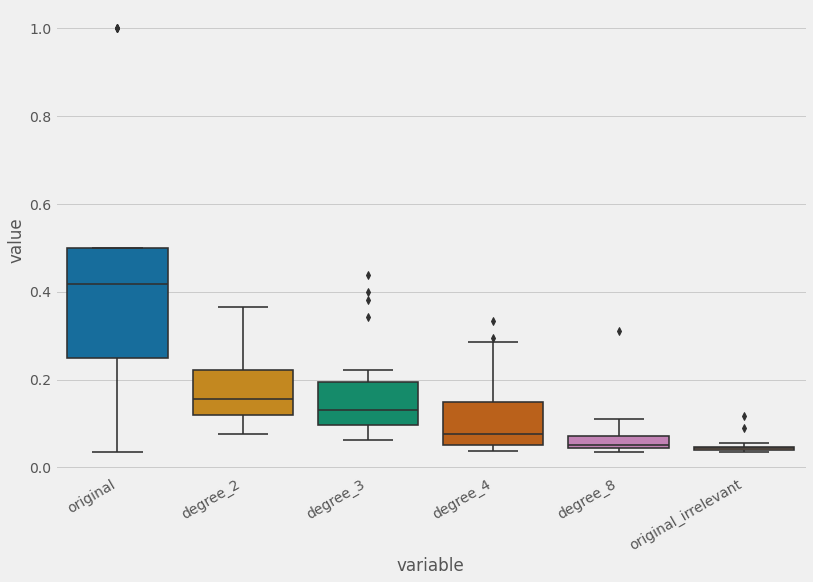

In [184]:
cols = ['original'] + \
       [x for x in rr_df.columns if x.startswith('degree_') and not x.endswith('split')] + \
       ['original_irrelevant']


print(cols)
rr_df_melted = pd.melt(rr_df, id_vars=['qid'], value_vars=cols)

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] =  1.6

plt.figure(figsize=(12,8))
ax = sns.boxplot(x="variable", y="value", data=rr_df_melted, palette="colorblind")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30, horizontalalignment='right')
print()